In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt

from utils import dt2int

from collections import namedtuple
from simglucose.patient.t1dpatient import T1DPatient

from tqdm.notebook import tqdm, trange
from deap import base, creator, tools, cma

In [2]:
# config
GLOBAL_SEED = 0
RESULTS_PATH = "results/"

# better plots
sns.set()

# tqdm
tqdm.pandas()

# Load data

In [3]:
# read and preprocess data
data = pd.read_csv("results/adult#001.csv")

# destructure data
data_t = data["Time"].map(lambda d: dt2int(d, fmt="%Y-%m-%d %H:%M:%S.%f")).to_numpy()
data_BG = data["BG"].to_numpy()
data_CGM = data["CGM"].to_numpy()
data_CHO = data["CHO"].to_numpy()
data_insulin = data["insulin"].to_numpy()

# normalize time
data_t -= data_t[0]

# scale down to minutes
data_t = data_t / 60.0

# clean
data_CHO = np.nan_to_num(data_CHO, nan=data_CHO[0])
data_insulin = np.nan_to_num(data_insulin, nan=data_insulin[0])

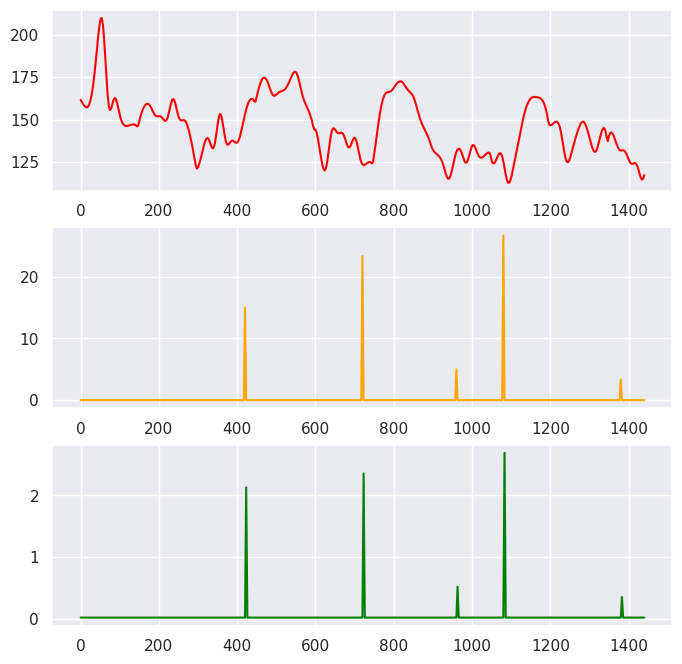

In [4]:
# visualize data
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(data_t, data_CGM, label="CGM", color="red")
plt.subplot(3, 1, 2)
plt.plot(data_t, data_CHO, label="CHO", color="orange")
plt.subplot(3, 1, 3)
plt.plot(data_t, data_insulin, label="insulin", color="green")
plt.show()

# Set up model

In [5]:
# required data structures
Action = namedtuple("patient_action", ['CHO', 'insulin'])

In [6]:
# load parameters
orig_params = pd.read_csv("parameters/vpatient_params.csv")
nominal_params = orig_params.mean(numeric_only=True)
est_params = ["kp2", "k1", "k2", "kp1", "ki", "ke1", "kmax", "kmin", "kabs", "kp3"]

# constrain parameters to be within the range
adult_params = orig_params[orig_params.Name.str.contains("adult")].loc[:, est_params]
p_range = np.stack([adult_params.min(), adult_params.max()], axis=1)
def constrain_params(p):
    return ((np.tanh(p) + 1) / 2) * (p_range[:, 1] - p_range[:, 0]) + p_range[:, 0]

# construct parameter dict
def construct_params(p):
    # p = [kp2, k1, k2, kp1, ki, ke1, kmax, kmin, kabs, kp3]
    return pd.Series({
        **nominal_params.drop("i").to_dict(),
        **dict(zip(est_params, constrain_params(p))),
    })

In [7]:
# time
t_span = (data_t[0], data_t[-1])
t_eval = data_t

# initial conditions
u0 = nominal_params.iloc[2:15].to_numpy()

def output(params):
    patient = T1DPatient.withParams(params)

    t_trace = t_eval # np.arange(*t_span)
    BG_trace = []
    dx_trace = []

    for t in t_trace:
        # get current action
        t_mask = np.abs(data_t - t).argmin()
        action = Action(CHO=data_CHO[t_mask], insulin=data_insulin[t_mask])

        # track variables
        BG_trace.append(patient.observation.Gsub)
        dx_trace.append(patient.derivative)

        patient.step(action)

    BG_trace = np.array(BG_trace)
    dx_trace = np.array(dx_trace)

    return t_trace, BG_trace , dx_trace

In [8]:
u0

array([  0.        ,   0.        , 262.86354937, 157.96548787,
         5.62647969,   0.        , 106.66196543, 106.66196543,
         3.15353575,  73.11359637,  75.40687256, 262.86354937,
        57.49653273])

# Set up algorithm

In [ ]:
# evolutionary algorithm parameters
NGEN = 150
SIGMA = 5
LAMBDA = 20

# target function
def evaluate(p):
    try:
        pred_t, pred_CGM = output(construct_params(p))
        return [np.sqrt(np.mean((np.log(pred_CGM + 1) - np.log(data_CGM + 1)) ** 2))]
    except:
        return [1e10]

# evolutionary algorithm setup
creator.create("FitnessMin", base.Fitness, weights=[-1.0])
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("evaluate", evaluate)

# enable multiprocessing
pool = mp.Pool()
toolbox.register("map", pool.map)

# inital parameter guess
p_guess = adult_params.mean().to_numpy()

# CMA-ES
strategy = cma.Strategy(centroid=p_guess, sigma=SIGMA, lambda_=LAMBDA)
toolbox.register("generate", strategy.generate, creator.Individual)
toolbox.register("update", strategy.update)

# track best individuals
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda i: i.fitness.values)
stats.register("avg_loss", np.mean)
stats.register("min_loss", np.min)
stats.register("max_loss", np.max)

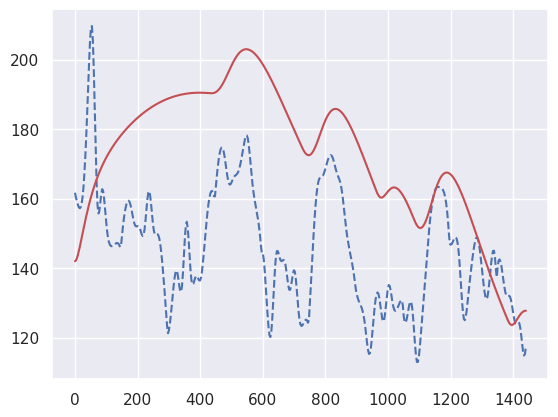

In [ ]:
p = adult_params.mean().to_numpy()
pred_t, pred_CGM = output(construct_params(p))
plt.plot(data_t, data_CGM, "b--")
plt.plot(pred_t, pred_CGM, "r")
plt.show()

In [ ]:
# train loop
def train(toolbox, ngen, stats, halloffame):
    loss_history = []
    for _ in trange(ngen):
        # generate a new population
        population = toolbox.generate()

        # evaluate the individuals
        fitnesses = toolbox.map(toolbox.evaluate, population)
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit

        if halloffame is not None:
            halloffame.update(population)

        # update the strategy with the evaluated individuals
        toolbox.update(population)

        record = stats.compile(population) if stats is not None else {}
        loss_history.append(record["min_loss"])

    return loss_history

# Train

In [ ]:
loss_history = train(toolbox, NGEN, stats, hof)

  0%|          | 0/200 [00:00<?, ?it/s]

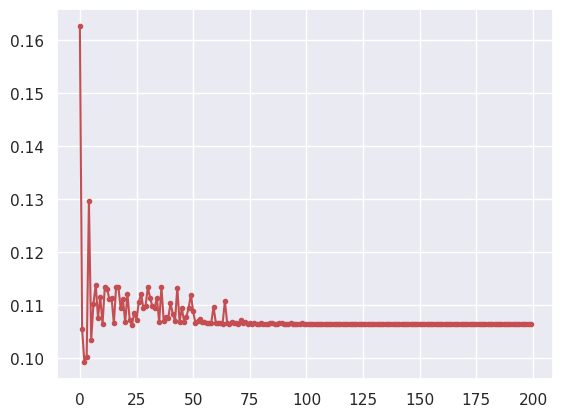

In [ ]:
plt.plot(loss_history, "r.-")
plt.show()

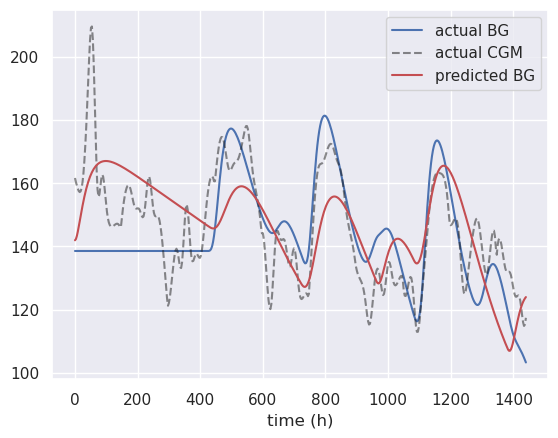

In [ ]:
# plot results
pred_t, pred_CGM = output(construct_params(hof[0]))

plt.plot(data_t, data_BG, "b", label="actual BG")
plt.plot(data_t, data_CGM, "k--", label="actual CGM", alpha=0.5)
plt.plot(pred_t, pred_CGM, "r", label="predicted BG")
plt.xlabel("time (h)")
plt.legend()
plt.show()